In [ ]:
import os
import numpy as np
import pandas as pd
import h5py
import bluepy as bp
from bluepy import Cell
from pprint import pprint
import matplotlib.pyplot as plt
import json
import shutil
import gc
import time
from sklearn.decomposition import PCA

import spikeinterface
import spikeinterface.full as si  
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw


import probeinterface as pi
from probeinterface import Probe
from probeinterface import generate_linear_probe
from probeinterface.plotting import plot_probe

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.size'] = '5'


#from pandarallel import pandarallel
#pandarallel.initialize(nb_workers = 10)
#syntax groupby.parallel_apply(func)

: 

In [14]:
path = '/gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/sims/reyes4s'

import os
print(np.sort(np.array(os.listdir(path)).astype(int)))
for file in os.listdir(path):
    print(file)

[1 2 3]
3
2
1


In [19]:
def find_close_gids(cells,probepos,radius):
    cpos = cells[list('xyz')]
    tiled = np.tile(probepos,(cpos.shape[0],1))
    dist = np.linalg.norm(cpos-tiled,axis = 1)
    return cells[dist<radius]

In [20]:
outpath= '../../../scratch/imbeni/sorting/output/0_silico/'
name = 'Hex0_4s_reyes128'
simpath = '/gpfs/bbp.cscs.ch/project/proj68/scratch/tharayil/spikeDetection/2af513c1-efc9-4bdf-9cae-159f74cb5732/0'
weightspath = '/gpfs/bbp.cscs.ch/project/proj68/scratch/tharayil/coeffsreyespuerta.h5'

In [21]:
out = outpath + name +'/' + name
outrec = out + '_rec'
outsort = out + '_true_spikes'

In [22]:
npieces = 1

In [23]:
# loading one piece to get the circuit
sim =  bp.Simulation(simpath + '/BlueConfig_0')
c = sim.circuit

report = sim.report('lfp')
data = report.get()

gids_id = pd.unique(data.columns)

ncells = len(set(data.columns))
fs = (1/report.t_step)*1000
fs_spikes = 1/ float(sim.config['Run_Default']['Dt']) # from the spike times resolution: where to get this automatically? sim get dt
piece_duration = report.t_end/1000
sites = int(data.shape[1]/len(report.gids)) # this should be the same for all pieces



Have keys ({'LFPWeightsPath', 'KeepModelData'}) that are not defined for section: Run
Ignoring unknown key: 'LFPWeightsPath'
Ignoring unknown key: 'KeepModelData'


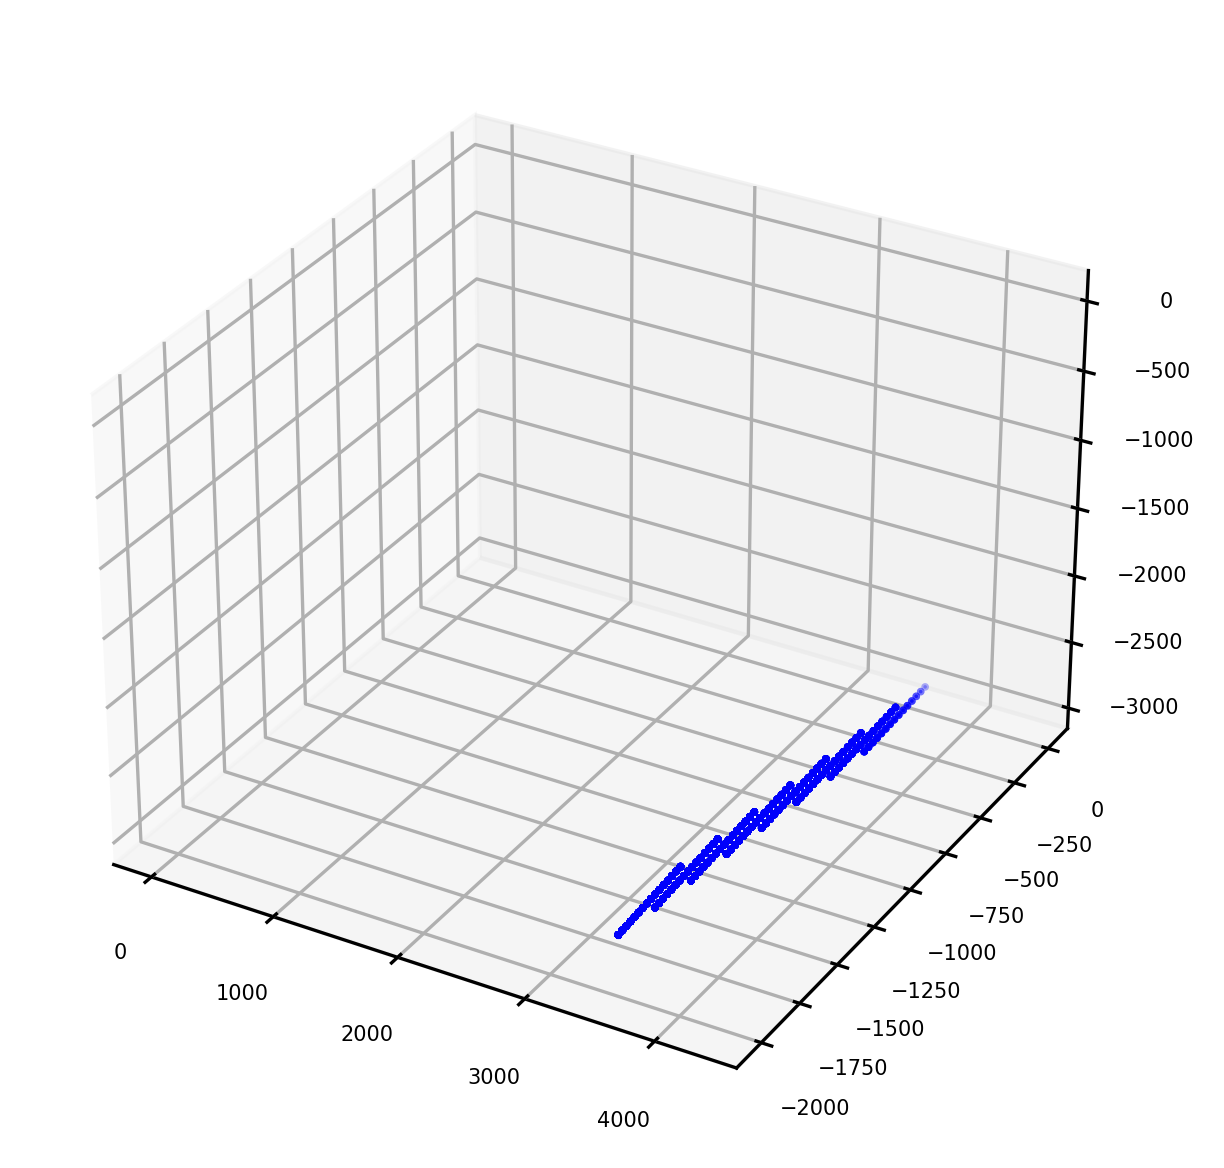

In [24]:
# loading weights file with channel locations
f = h5py.File(weightspath, 'r')

locationstmp = np.array([0,0,0])
for i in range(sites):
    temp = np.array(f['electrodes']['reyespuerta_'+str(i)]['location']) # or database.getvalue()
    locationstmp = np.c_[locationstmp, temp]
locations = locationstmp.T[1:]



#%matplotlib notebook 
# if you want it interactive
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(128):
    ax.scatter(locations[:i,0],locations[:i,1],locations[:i,2], s = 0.7, c = 'b', alpha = 0.3)
    fig.canvas.draw()
    fig.canvas.flush_events()
    time.sleep(0.01)
plt.show()

In [25]:
# find all cells closer than radius to at least one contact
cells = c.cells.get({'$target':'hex0'})
radius = 50

all_close_gids = []
for location in locations:
    close_gids_df = find_close_gids(cells, location, radius)
    close_gids = list(close_gids_df.index)
    all_close_gids = all_close_gids + close_gids
    
all_close_gids = list(set(all_close_gids))


In [26]:
# loading traces and spikes for all pieces

pieces = range(npieces)

traces_list = []
spikes_list = []

for i in pieces:
    t0 = time.time()
    print(f'Running piece {i}')
    sim =  bp.Simulation(simpath + '/BlueConfig_'+str(i))
    report = sim.report('lfp')
    data = report.get()
    print('Data loaded in ',time.time()-t0)
    
    sites = int(data.shape[1]/len(report.gids)) # this should be the same for all pieces
    
    data.columns = pd.MultiIndex.from_product([gids_id, np.arange(sites)], names=['gid', 'contact'])
    t1 = time.time()
    traces_piece = data.groupby(level = 'contact', axis = 1).sum()*1000

    #traces_piece = data.groupby(level = 'contact', axis = 1).parallel_apply(np.sum, axis = 1)*1000
    print('groupby time',time.time()-t1)
    traces_list.append(traces_piece)
    
    spikes_piece = sim.spikes.get(gids = all_close_gids)
    spikes_list.append(spikes_piece)
    del sim, report, data, traces_piece
    gc.collect()
          
traces =  pd.concat(traces_list, axis = 0)
spikes =  pd.concat(spikes_list)


# create sorting object
times = np.int_(np.array(spikes.index)*fs_spikes/1000) # it must be an integer, = samples or frames
labels = spikes.values

sorting_true = se.NumpySorting.from_times_labels([times], [labels], fs_spikes)
print(sorting_true)
print('Saving sorting')
#shutil.rmtree(outsort,ignore_errors = True)
#sorting_true = sorting_true.save(folder = outsort)

Have keys ({'LFPWeightsPath', 'KeepModelData'}) that are not defined for section: Run
Ignoring unknown key: 'LFPWeightsPath'
Ignoring unknown key: 'KeepModelData'


Running piece 0
Data loaded in  47.655855655670166
groupby time 134.90139865875244
NumpySorting: 134 units - 1 segments - 0.0kHz
Saving sorting


In [ ]:
print(ncells)
print(fs, piece_duration)

In [ ]:
plt.plot(traces.iloc[:,0])

In [ ]:
traces.max().hist()

In [ ]:
traces.isnull().sum().sum()

In [ ]:
for col in traces.columns:
    print(col)

# Creating recording object 

In [ ]:
num_channels = sites
sampling_frequency = fs # in Hz
durations = [piece_duration*npieces]  #  in s
num_segments = 1
num_timepoints = [int(sampling_frequency * d) for d in durations]

recording = se.NumpyRecording(traces_list=[np.array(traces)], sampling_frequency=sampling_frequency)
print(recording)

# Create and pair probe

#### neuropixel 384
import MEAutility as MEA
neuropix = MEA.return_mea('Neuropixels-384')
positions = neuropix.positions[:, 1:3]

probe = Probe(ndim=2, si_units='um')
probe.set_contacts(positions=positions, shapes='circle', shape_params={'radius': 5})
probe.create_auto_shape(probe_type='tip', margin = 50)
#probe = generate_linear_probe(num_elec=sites, ypitch=20, contact_shapes='circle', contact_shape_params={'radius': 6})

#### the probe has to be wired to the recording
probe.set_device_channel_indices(np.arange(sites))

In [ ]:
# reyes 16x8
ypitch = 75
xpitch = 200
nshank = 8
nelec = 16
relec = 12.5 
shank = pi.generator.generate_linear_probe(num_elec=nelec, ypitch=ypitch, contact_shapes='circle', contact_shape_params={'radius': relec})
shank.create_auto_shape(probe_type='tip', margin = 50)

def shift(original_probe,i,d):
    pr = original_probe.copy()
    pr.move([i*d,0])
    return pr
    
shanks = [shift(shank,i,xpitch) for i in range(nshank)]
probe = pi.combine_probes(shanks)


multi_shank = probe.to_3d()
multi_shank.rotate(90,axis=[0,0,1])

multi_shank.move(np.array([-(xpitch*nshank)/2,0,-(ypitch*nshank)/2]))

somaPos = c.cells.get({'$target': 'hex0'},properties=[bp.Cell.X, bp.Cell.Y, bp.Cell.Z])
center = np.mean(somaPos,axis=0)

pca = PCA(n_components=3)
pca.fit(somaPos)
main_axis = pca.components_[0]

elevation = np.arctan2(np.sqrt(main_axis[0]**2+main_axis[1]**2),main_axis[2])
azimuth = np.arctan2(main_axis[1],main_axis[0])

multi_shank.rotate(elevation*180/np.pi,axis=[0,1,0])
multi_shank.rotate(azimuth*180/np.pi,axis=[0,0,1])
multi_shank.move(center)

multi_shank.set_device_channel_indices(np.arange(sites))
#recording = recording.set_probe(multi_shank)


In [ ]:
#probe_3d = Probe(ndim=3, si_units='um')
#plane_axes = [[1,0,0],[0,1,0]]*(nshank*nelec)
#probe_3d.set_contacts(positions=locations, plane_axes = plane_axes, shapes='circle', shape_params={'radius': relec})

In [ ]:
sw.plot_timeseries(recording, time_range = [0,durations[0]])

In [ ]:
pi.plotting.plot_probe(probe, with_channel_index=True, with_device_index=True)

In [ ]:
recording_f = si.bandpass_filter(recording, freq_min=300, freq_max=6000)
recording_cmr = si.common_reference(recording_f, reference='global', operator='median')

#shutil.rmtree(outrec,ignore_errors = True)
#rec_ready = recording_cmr.save(folder = outrec, format='binary')#, n_jobs = 10, total_memory = '30G')

In [ ]:
%reset